In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

## Download the data

In [2]:
import requests
quakes_response=requests.get("http://earthquake.usgs.gov/fdsnws/event/1/query.geojson",
                    params={
        'starttime':"2000-01-01",
        "maxlatitude":"58.723",
        "minlatitude":"50.008",
        "maxlongitude":"1.67",
        "minlongitude":"-9.756",
        "minmagnitude":"1",
        "endtime":"2015-07-13",
        "orderby":"time-asc"}
                   )

In [3]:
quakes_response

<Response [200]>

In [4]:
type(quakes_response)

requests.models.Response

## Parse the data as JSON

In [5]:
import json

In [6]:
requests_json = json.loads(quakes_response.text)

## Investigate the data to discover how it is structured.

In [7]:
type(requests_json)

dict

In [8]:
requests_json.keys()

dict_keys(['bbox', 'type', 'metadata', 'features'])

In [9]:
type(requests_json['features'])

list

In [10]:
len(requests_json['features'])

110

In [11]:
type(requests_json['features'][0])

dict

In [12]:
requests_json['features'][0].keys()

dict_keys(['type', 'id', 'properties', 'geometry'])

In [13]:
requests_json['features'][0]['properties']['mag']

2.6

In [14]:
requests_json['features'][0]['geometry']['coordinates']

[-2.81, 54.77, 14]

## Find the largest quake

In [15]:
quakes = requests_json['features']

In [16]:
largest_so_far = quakes[0]

for quake in quakes:
    if quake['properties']['mag'] > largest_so_far['properties']['mag']:
        largest_so_far = quake
        
largest_so_far

{'geometry': {'coordinates': [-2.15, 52.52, 9.4], 'type': 'Point'},
 'id': 'usp000bcxg',
 'properties': {'alert': None,
  'cdi': None,
  'code': 'p000bcxg',
  'detail': 'http://earthquake.usgs.gov/fdsnws/event/1/query?eventid=usp000bcxg&format=geojson',
  'dmin': None,
  'felt': None,
  'gap': None,
  'ids': ',usp000bcxg,atlas20020922235314,',
  'mag': 4.8,
  'magType': 'mb',
  'mmi': None,
  'net': 'us',
  'nst': 268,
  'place': 'England, United Kingdom',
  'rms': None,
  'sig': 354,
  'sources': ',us,atlas,',
  'status': 'reviewed',
  'time': 1032738794600,
  'title': 'M 4.8 - England, United Kingdom',
  'tsunami': 0,
  'type': 'earthquake',
  'types': ',impact-text,origin,phase-data,',
  'tz': None,
  'updated': 1426874123970,
  'url': 'http://earthquake.usgs.gov/earthquakes/eventpage/usp000bcxg'},
 'type': 'Feature'}

In [17]:
print(largest_so_far['properties']['mag'])

4.8


In [18]:
lat=largest_so_far['geometry']['coordinates'][1]
long=largest_so_far['geometry']['coordinates'][0]
print("Latitude:", lat, "Longitude:", long)

Latitude: 52.52 Longitude: -2.15


## Get a map at the point of the quake

In [19]:
import requests
def request_map_at(lat,long, satellite=False,zoom=12,size=(400,400),sensor=False):
  base="http://maps.googleapis.com/maps/api/staticmap?"
  
  params=dict(
    sensor= str(sensor).lower(),
    zoom= zoom,
    size= "x".join(map(str,size)),
    center= ",".join(map(str,(lat,long)))
  )
  if satellite:
    params["maptype"]="satellite"

  return requests.get(base,params=params)

In [20]:
import IPython
map_png=request_map_at(lat, long,zoom=10)

## Display the map

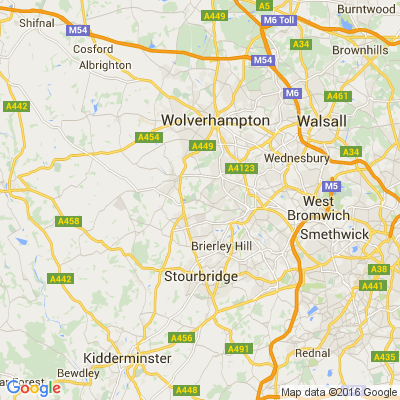

In [21]:
IPython.core.display.Image(map_png.content)

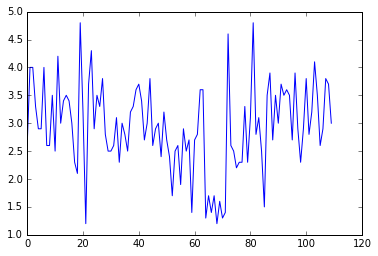

In [22]:
plt.plot([  quake['properties']['mag'] for quake in quakes  ]) 